In [1]:
import numpy as np
import torch_geometric
from mlcolvar.data import graph as gdata

In [2]:
def test_get_data() -> torch_geometric.data.Batch:
    # TODO: This is not a real test, but a helper function for other tests.
    # Maybe should change its name.

    numbers = [8, 1, 1]
    positions = np.array(
        [
            [[0.0, 0.0, 0.0], [0.07, 0.07, 0.0], [0.07, -0.07, 0.0]],
            [[0.0, 0.0, 0.0], [-0.07, 0.07, 0.0], [0.07, 0.07, 0.0]],
            [[0.0, 0.0, 0.0], [0.07, -0.07, 0.0], [0.07, 0.07, 0.0]],
            [[0.0, 0.0, 0.0], [0.0, -0.07, 0.07], [0.0, 0.07, 0.07]],
            [[0.0, 0.0, 0.0], [0.07, 0.0, 0.07], [-0.07, 0.0, 0.07]],
            [[0.1, 0.0, 1.1], [0.17, 0.07, 1.1], [0.17, -0.07, 1.1]],
        ],
        dtype=np.float64
    )
    cell = np.identity(3, dtype=float) * 0.2
    graph_labels = np.array([[[0]], [[1]]] * 3)
    node_labels = np.array([[0], [1], [1]])
    z_table = gdata.atomic.AtomicNumberTable.from_zs(numbers)

    config = [
        gdata.atomic.Configuration(
            atomic_numbers=numbers,
            positions=positions[i],
            cell=cell,
            pbc=[True] * 3,
            node_labels=node_labels,
            graph_labels=graph_labels[i],
        ) for i in range(0, 6)
    ]
    dataset = gdata.create_dataset_from_configurations(
        config, z_table, 0.1, show_progress=False
    )

    loader = gdata.GraphDataModule(
        dataset,
        lengths=(1.0,),
        batch_size=10,
        shuffle=False,
    )
    loader.setup()

    return next(iter(loader.train_dataloader()))

In [3]:
from mlcolvar.data.graph import GraphDataModule
from mlcolvar.utils.io import create_dataset_from_trajectories

dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = GraphDataModule(dataset_graph, shuffle=[1, 0])
print(datamodule_graph)


from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[1])


  BASEDATA  : [ 1600 󰡷 | [6 9] 󰝨 | 8.000000 󰳁 ]
  TRAINING  : [ 1280 󰡷 | 1600  |   ]
 VALIDATION : [  320 󰡷 | 1600  |   ]
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [10]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.cutoff,
                        atomic_numbers=dataset_graph.atomic_numbers,
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

In [11]:
from mlcolvar.cvs.supervised.deeptda_merged import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        layers=[21, 15, 10, 1],
                        gnn_model=gnn_model)

model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    layers=[21, 15, 10, 1],
                    gnn_model=None)



In [12]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='gpu',
    max_epochs=500,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_graph, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [13]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='gpu',
    max_epochs=500,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_ff, datamodule_ff)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [14]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

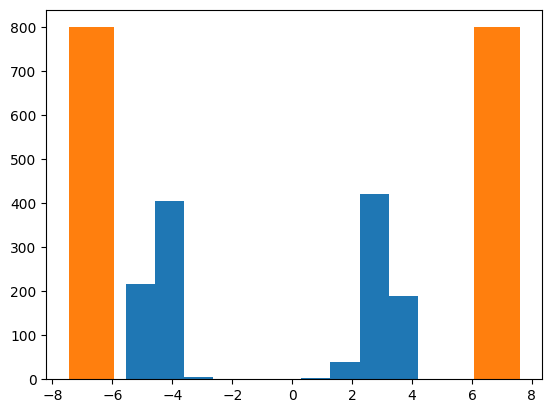

In [15]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze())
plt.hist(out_ff.detach().squeeze())
plt.show()